# **Importing Libraries**

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# **Data Loading**

In [18]:
data = pd.read_csv("data.csv")

# **Data Preprocessing**

In [ ]:
# Drop completely empty rows
data.dropna(how='all', inplace=True)

# Keep only valid Gender entries
valid_genders = ['Male', 'Female', 'Non-binary']
data = data[data['Gender'].isin(valid_genders)]

# Clean Age: convert to numeric and keep in a realistic range
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
data = data[(data['Age'] >= 10) & (data['Age'] <= 100)]

# Reset index after cleaning
data.reset_index(drop=True, inplace=True)

# Fill missing values with forward fill
data.ffill(inplace=True)

# Drop User_ID since it's not a feature
if 'User_ID' in data.columns:
    data.drop('User_ID', axis=1, inplace=True)

# Label Encoding
# Fit encoders on the *entire* data after cleaning
le_gender = LabelEncoder()
le_platform = LabelEncoder()
le_emotion = LabelEncoder()

data['Gender'] = le_gender.fit_transform(data['Gender'])
data['Platform'] = le_platform.fit_transform(data['Platform'])
data['Dominant_Emotion'] = le_emotion.fit_transform(data['Dominant_Emotion'])


# Define features and target
feature_cols = [
    'Age', 'Gender', 'Platform',
    'Daily_Usage_Time(minutes)', 'Posts_Per_Day', # Corrected column name
    'Likes_Received_Per_Day', 'Comments_Received_Per_Day',
    'Messages_Sent_Per_Day'
]
X = data[feature_cols]
y = data['Dominant_Emotion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **Bayes Theorem Implementation**

In [20]:
class SimpleBayesClassifier:
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = y.unique()
        self.priors = y.value_counts(normalize=True).to_dict()

        self.cond_probs = {}
        for c in self.classes:
            self.cond_probs[c] = {}
            X_c = X[y == c]
            for col in X.columns:
                self.cond_probs[c][col] = X_c[col].value_counts(normalize=True).to_dict()

    def predict(self, X_test):
        predictions = []
        for _, row in X_test.iterrows():
            posteriors = {}
            for c in self.classes:
                prob = self.priors.get(c, 1e-6)  # Start with prior
                for col in X_test.columns:
                    value = row[col]
                    prob *= self.cond_probs[c][col].get(value, 1e-6)  # Use conditional probability
                posteriors[c] = prob
            predictions.append(max(posteriors, key=posteriors.get))
        return predictions

# **Model Training**

In [21]:
# Train custom Naive Bayes classifier
nb_model = SimpleBayesClassifier()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Save the model and encoders
joblib.dump(nb_model, 'my_model.joblib')
joblib.dump(le_gender, 'le_gender.joblib')
joblib.dump(le_platform, 'le_platform.joblib')
joblib.dump(le_emotion, 'le_emotion.joblib')

['le_emotion.joblib']

# **Model Evaluation**

Accuracy: 0.8540540540540541

 Classification Report:
              precision    recall  f1-score   support

       Anger       0.79      0.76      0.78        25
     Anxiety       0.96      0.84      0.90        31
     Boredom       0.76      0.96      0.85        26
   Happiness       0.83      0.95      0.89        37
     Neutral       0.86      0.86      0.86        37
     Sadness       0.95      0.72      0.82        29

    accuracy                           0.85       185
   macro avg       0.86      0.85      0.85       185
weighted avg       0.86      0.85      0.85       185



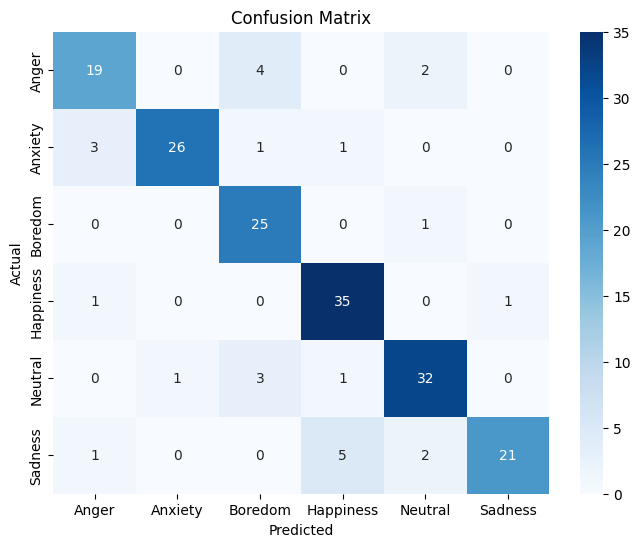

In [22]:
# Make predictions and evaluate
y_pred = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_emotion.classes_))


#-------------------------------------------------------------------------------
# graph of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le_emotion.classes_, yticklabels=le_emotion.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#-------------------------------------------------------------------------------

# **Predictions on New Data**

In [15]:
# Load model and encoders
nb_model = joblib.load('my_model.joblib')
le_gender = joblib.load('le_gender.joblib')
le_platform = joblib.load('le_platform.joblib')
le_emotion = joblib.load('le_emotion.joblib')

# Example new data (replace with real input)
new_data = pd.DataFrame({
    'Age': [28, 35],
    'Gender': ['Female', 'Male'],
    'Platform': ['Instagram', 'Twitter'],
    'Daily_Usage_Time(minutes)': [120, 90],
    'Posts_Per_Day': [3, 2],
    'Likes_Received_Per_Day': [150, 80],
    'Comments_Received_Per_Day': [20, 10],
    'Messages_Sent_Per_Day': [50, 40]
})

# Apply encodings
new_data['Gender'] = le_gender.transform(new_data['Gender'])
new_data['Platform'] = le_platform.transform(new_data['Platform'])

# Ensure the correct column order
feature_cols = [
    'Age', 'Gender', 'Platform',
    'Daily_Usage_Time(minutes)', 'Posts_Per_Day',
    'Likes_Received_Per_Day', 'Comments_Received_Per_Day',
    'Messages_Sent_Per_Day'
]
new_data = new_data[feature_cols]

# Predict emotions
predicted_labels = nb_model.predict(new_data)
predicted_emotions = le_emotion.inverse_transform(predicted_labels)

# Display predictions
print("Predicted Emotions for New Users:")
for i, emotion in enumerate(predicted_emotions):
    print(f"User {i + 1}: {emotion}")

Predicted Emotions for New Users:
User 1: Happiness
User 2: Neutral


# **Conclusion**

This notebook successfully implements a simple Naive Bayes classifier to predict dominant emotions based on social media usage data. The data was preprocessed through cleaning, handling missing values, and encoding categorical features. The custom Bayes classifier was trained on the prepared data, achieving an accuracy of **85.4%**. The model's performance was further evaluated using a classification report, highlighting precision, recall, and F1-score for each dominant emotion, and a confusion matrix, which visually represents the model's predictions against the actual labels. Finally, the trained model and encoders were saved for future use and demonstrated with predictions on new data. While this model provides a baseline, further improvements could explore different classification algorithms, feature engineering techniques, and more extensive hyperparameter tuning.